# Lab 8
This week we will find out how `odeint` can be used to integrate systems of differential equations of the form
\begin{align*}
\frac{\mathrm{d}\mathbf{y}}{\mathrm{d}t} = f(\mathbf{y}, t),
\end{align*}
where $\mathbf{y}$ is a **vector** of dependent variables and $f$ is a function of $\mathbf{y}$.

We will also show how you can approximate solutions to systems of DEs that you may not be able to solve analytically.

## Setup

In [1]:
from numpy import arange, empty, exp, array, linspace, isclose, allclose, sin, pi
from scipy.integrate import odeint
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd

## A Nonlinear DE

Imagine that the number of rabbits in an area as a function of time is modelled by $r(t)$ and the number of foxes in the same area at the same time is given by $f(t)$. We can modelled their linked fates using the coupled DEs
\begin{align*}
\frac{\mathrm{d}r}{\mathrm{d}t} &= 0.08 r - 0.0004 rf, \\
\frac{\mathrm{d}f}{\mathrm{d}t} &= -0.09 f + 0.0005 rf,
\end{align*}
with initial conditions $r_0 = 300$ and $f_0 = 100$. See Section 6.3 (and the rest of Chapter 6) if you are curious about where this equation comes from.

For us, it is important to note that

- this system of DEs cannot be represented as matrix multiplied by a $(r\, f)^\intercal$ vector and
- we have not studied how to solve this equation.

We can still define it as a Python function, however. Note that in the following function `rf` is a variable that contains $r$ and $f$ as a vector (actually a NumPy `array`, but it is one-dimensional so we call it a vector).

In [2]:
def drfdt(rf, t):
    r, f = rf
    drdt = 0.08*r - 0.0004*r*f
    dfdt = -0.09*f + 0.0005*r*f
    return array([drdt, dfdt])

`odeint` works almost exactly the same as it does in the one-dimensional case (and in fact makes a bit more sense now in some respects). Note that the initial values are input as `[300, 100]`, and that the first element of $t$ must correspond to the time of those initial values (in this case `t[0] == 0`). 

<AxesSubplot:xlabel='t', ylabel='value'>

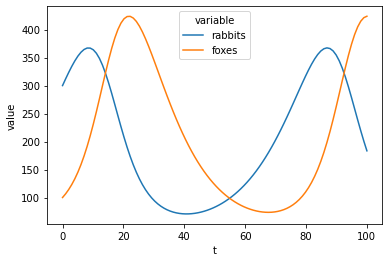

In [3]:
t = linspace(0, 100, 100)
rf = odeint(drfdt, [300, 100], t)
data = pd.DataFrame({
    'rabbits': rf[:,0], 'foxes': rf[:,1], 't': t
})
data = data.melt(id_vars=['t'])
sns.lineplot(data=data, x='t', y='value', hue='variable')

Just like when we used `odeint` with a scalar function, `odeint` will happily figure out the values of $r$ and $f$ only when you need them, for instance only at the instant 40 years hence:

In [4]:
rf = odeint(drfdt, [300, 100], [0, 40])
print(rf[-1, 0], 'rabbits')
print(rf[-1, 1], 'foxes')

70.757766160244 rabbits
208.23878627992096 foxes


If you wanted to figure out exactly when the number of rabbits reaches its lowest ebb, you can minimize the result numerically, again using SciPy.

In [5]:
def rabbits(t):
    return odeint(drfdt, [300, 100], [0, t])[-1, 0]

result = minimize(rabbits, 40)
print(result)

      fun: 70.67226332711697
 hess_inv: array([[3.23550154]])
      jac: array([-3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([40.73864735])


C:\Users\z9801684\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [16]:
minimize?

You get a heap of diagnostic information from `minimize`, but the most important thing is that "Optimization terminated successfully" and that the value is stored in `x`:

In [6]:
print('rabbits rebounded after', result.x[0], 'years')

rabbits rebounded after 40.738647346149506 years


# Exercises
We will now numerically solve a differential equation that we cannot solve analytically.

Pendulum motion can be defined as
\begin{align*}
\frac{\mathrm{d}^2\theta}{\mathrm{d}t^2} = -\frac{g}{L}\sin\theta,
\end{align*}
where $g$ is gravitational acceleration, $L$ is the length of the pendulum, and $\theta$ is the
angle the pendulum makes with the vertical as shown in the figure.

<div style="align: left; text-align:center;">
<img src="images/hold-your-colour.png" style="width: 150px;"/>
Figure 1: A simple pendulum
</div>

The above equation is a second-order nonlinear differential equation and we don’t have a
way to solve this equation algebraically. That is, we can’t use the characteristic equation
method or method of undetermined coefficients to solve this equation.

We can, however, convert it into a system of first-order DEs and find an approximate solution using `odeint`. By setting $v=\mathrm{d}\theta/\mathrm{d}t$, we obtain the equivalent formulation
\begin{align*}
\frac{\mathrm{d}\theta}{\mathrm{d}t} &= v \\
\frac{\mathrm{d}v}{\mathrm{d}t} &= -\frac{g}{L}\sin\theta.
\end{align*}
Suppose that $g/L = 10$. Write a function to calculate the vector
$\left(\begin{array}{1}\frac{\mathrm{d}\theta}{\mathrm{d}t}\\
\frac{\mathrm{d}v}{\mathrm{d}t}\end{array}\right)$ as a function of $\left(\begin{array}{1}\theta\\v\end{array}\right)$ and $t$. (Note that NumPy does not care whether you return a column or row vector. Usually it figures out what you mean from the context.)

In [7]:
def dthetavdt(thetav, t):
    theta, v = thetav
    dthetadt = v
    dvdt = -10*sin(theta)
    return array([dthetadt, dvdt])

The following cell should run without errors then print a friendly message.

In [8]:
assert allclose(dthetavdt([pi/2, 0], 0), [0, -10.0])
assert allclose(dthetavdt([pi/12, 0], 0), [0, -2.5881904510252074])
assert allclose(dthetavdt([0, 1], 0), [1, 0])
print('Your code works!')

Your code works!


Use `odeint` to plot $\theta$ on the interval $0\leq t \leq 2.5$ when $\theta_0=\frac{\pi}{12}$ and $v_0=0$.

<AxesSubplot:xlabel='t', ylabel='value'>

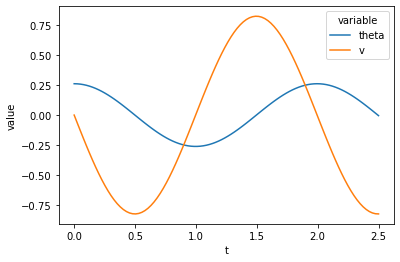

In [10]:
t = linspace(0, 2.5, 100)
thetav = odeint(dthetavdt, [pi/12, 0], t)
data = pd.DataFrame({
    'theta': thetav[:,0], 'v': thetav[:,1], 't': t
})
data = data.melt(id_vars=['t'])
sns.lineplot(data=data, x='t', y='value', hue='variable')

In the following cell, calculate and print the values for $\theta(2.5)$ and $v(2.5)$ when $\theta_0=\frac{\pi}{12}$ and $v_0=0$.

In [13]:
thetav = odeint(dthetavdt, [pi/12, 0], [0, 2.5])
print(f'theta(2.5) = {thetav[-1,0]}')
print(f'v(2.5) = {thetav[-1,1]}')

theta(2.5) = -0.004681934744160246
v(2.5) = -0.8253870220740621


Plot $\theta$ on the interval $0\leq t \leq 2.5$ when $\theta_0=\frac{\pi}{2}$ and $v_0=0$.

<AxesSubplot:xlabel='t', ylabel='value'>

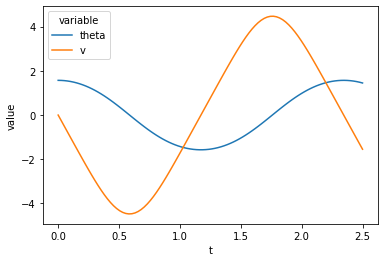

In [14]:
t = linspace(0, 2.5, 100)
thetav = odeint(dthetavdt, [pi/2, 0], t)
data = pd.DataFrame({
    'theta': thetav[:,0], 'v': thetav[:,1], 't': t
})
data = data.melt(id_vars=['t'])
sns.lineplot(data=data, x='t', y='value', hue='variable')

In the following cell, calculate and print the values for $\theta(2.5)$ and $v(2.5)$ when $\theta_0=\frac{\pi}{2}$ and $v_0=0$.

In [15]:
thetav = odeint(dthetavdt, [pi/2, 0], [0, 2.5])
print(f'theta(2.5) = {thetav[-1,0]}')
print(f'v(2.5) = {thetav[-1,1]}')

theta(2.5) = 1.4510997040393572
v(2.5) = -1.5453873087645622
